# 2D Linear Elasticity
> This blog focuses on generating displacement results for ad 2D cantilever beam after varying the location and magnitude of the force on the top side.
- hide_binder_badge: true
- comments: true
- use_math: true

In [1]:
from __future__ import print_function
import region_selector_2d as rs
from fenics import *
from mshr import *
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
length = 15.0 # [mm]
thickness = 3.0 # [mm]
resolution = 2 # [Nodes/mm]

resX = int(resolution*length) # N_elements_x = N_nodes_x - 1
resY = int(resolution * thickness)# N_elements_y = N_nodes_y - 1

delta_x = length/(resX+1)
delta_y = thickness/(resY+1)

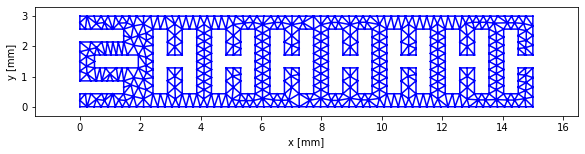

In [40]:
geom = Rectangle(Point(0.0, 0.0), Point(length, thickness))

eps = 0.001
geom -= Rectangle(Point(0.0, delta_y+eps), Point(3*delta_x, 2*delta_y-eps))
geom -= Rectangle(Point(0.0, thickness-2*delta_y+eps), Point(3*delta_x, thickness-1*delta_y-eps))
geom -= Rectangle(Point(delta_x, 3*delta_y+eps), Point(4*delta_x, 4*delta_y-eps))

for c_x in range(5,resX,2):
    geom -= Rectangle(Point(c_x*delta_x+eps, 1*delta_y+eps), Point((c_x+1)*delta_x-eps, thickness-1*delta_y-eps)) 
for c_x in range(6,resX+1,4):
    geom -= Rectangle(Point(c_x*delta_x-eps, 3*delta_y+eps), Point((c_x+1)*delta_x+eps, 4*delta_y-eps)) 

mesh = generate_mesh(geom, 30)

plt.figure(figsize=(10,2))
plot(mesh, color='b')
plt.margins(0.1)
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
plt.show()


In [4]:
fixed_region_lower = rs.GetLinearBoundary.from_points(Point(0.0,0.0), Point(0.0,delta_y))
fixed_region_upper = rs.GetLinearBoundary.from_points(Point(0.0,thickness-delta_y), Point(0.0,thickness))

boundaries = MeshFunction('size_t', mesh, mesh.topology().dim()-1)

In [5]:
V = VectorFunctionSpace(mesh, "Lagrange", 2)
du = TrialFunction(V)
u = Function(V, name="Displacement")
v = TestFunction(V)

In [6]:
bc_1 = DirichletBC(V, Constant((0.0,0.0)), fixed_region_lower)
bc_2 = DirichletBC(V, Constant((0.0,0.0)), fixed_region_upper)
bc = [bc_1, bc_2]

In [7]:
def eps(u):
    return sym(grad(u))

def sigma(u,E):
    nu = 0.3
    mu = E / (2.0 * (1.0 + nu))
    lmbda = E*nu / ((1.0 + nu) * (1.0-2.0*nu))
    return lmbda*tr(eps(u))*Identity(mesh.topology().dim()) + 2.0*mu*eps(u)


In [8]:
batch_it = 1
simulation_iter = 50

u_x = np.zeros([resY+2,resX+2,simulation_iter])
u_y = np.zeros([resY+2,resX+2,simulation_iter])
load_data = np.empty([simulation_iter,5])

for it in range(simulation_iter):
    #print(f'Iteration: {it}')
    point_x = random.random()*length
    point_y = thickness
    #point_y = random.random()*thickness
    loadRegion = rs.GetLinearBoundary.from_points(Point(point_x-0.4, point_y), Point(point_x+0.4, point_y))
    boundaries.set_all(0)
    fixed_region_lower.mark(boundaries, 1)
    fixed_region_upper.mark(boundaries, 1)
    loadRegion.mark(boundaries, 2)
    ds = Measure('ds', domain=mesh, subdomain_data=boundaries)
    load_x = random.random()*2000.0 - 1000.0
    load_y = random.random()*2000.0 - 1000.0
    E = np.random.choice(14,1)[0]*5000.0 + 70000.0
    load_data[it,:] = np.array([E, point_x, point_y, load_x, load_y])
    load = Constant((load_x,load_y)) # [N/mm]
    a = inner(sigma(du,E), eps(v))*dx
    L = dot(load,v)*ds(2)
    solve(a == L, u, bc)
    
    for x in range(resX+2):
        for y in range(resY+2):
            u_xy = u(x*delta_x, y*delta_y)
            u_x[y,x,it] = u_xy[0]
            u_y[y,x,it] = u_xy[1]


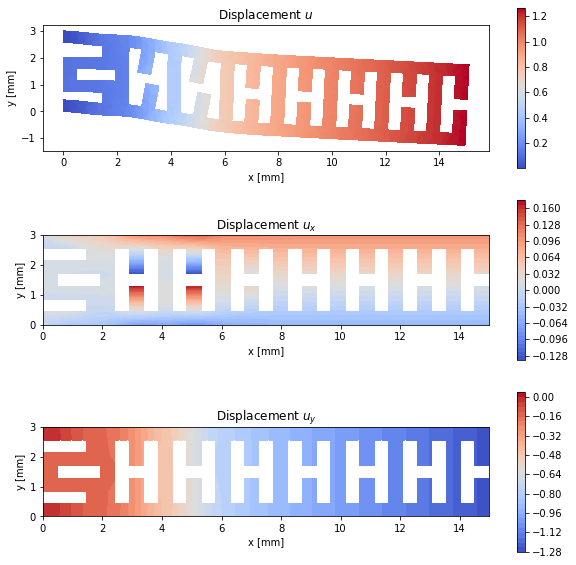

In [103]:
def plot_result(u, u_title):
    if not u.ufl_shape:
        p = plot(u, cmap='coolwarm', title='Displacement '+u_title)
    else:
        p = plot(u, mode='displacement', cmap='coolwarm', title='Displacement '+u_title)
    plt.colorbar(p)
    plt.xlabel("x [mm]")
    plt.ylabel("y [mm]")

plt.figure(figsize=(10,10))

plt.subplot(3,1,1)
plot_result(u, "$u$")

plt.subplot(3,1,2)
plot_result(dot(u, Constant((1,0))), "$u_x$")

plt.subplot(3,1,3)
plot_result(u.sub(1), "$u_y$")

plt.show()